<a href="https://colab.research.google.com/github/pa-blan/Cat-Classifier/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/pa-blan/

fatal: destination path 'Cat-Classifier' already exists and is not an empty directory.


In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

In [2]:
#!nvidia-smi

Der Befehl "nvidia-smi" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [12]:
# Einlesen der Daten

import os
import numpy as np
from tqdm import tqdm_notebook as tqdm
from PIL import Image

def read_images(path):
    files = os.listdir(path)
    #Hier wird geprüft ob die Bilder das Format jpg haben
    files = [file for file in files if file[-4:] == ".jpg"]
    
    images = []
    for file in tqdm(files):
        try:
            image = Image.open(os.path.join(path, file))

            # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.resize
            image = image.resize((224, 224), Image.LANCZOS)

            # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.convert
            image = image.convert("RGB")

            image = np.asarray(image)

            images.append(image)

        except OSError:
            pass
    
    return images
  
#Hier werd die Funktion verwendet
# base = read_images(os.path.join("Cat-Classifier", "data", "base"))
# s = read_images(os.path.join("Cat-Classifier", "data", "s"))
# c = read_images(os.path.join("Cat-Classifier", "data", "c"))

base = read_images(os.path.join("data", "base"))
s = read_images(os.path.join("data", "s"))
c = read_images(os.path.join("data", "c"))
o = read_images(os.path.join("data", "open"))
  
base = np.asarray(base)
s = np.asarray(s)
c = np.asarray(c)
o = np.asarray(o)

X = np.concatenate([base, s, c, o])
X = X.astype(np.float32)

# Daten werden in 0 und 1 
y_base = np.full(len(base), 0.)
y_s = np.full(len(s), 1.)
y_c = np.full(len(c), 2.)
y_o = np.full(len(o), 3.)

# y Daten hintereinander anhängen
y = np.concatenate([y_base, y_s, y_c, y_o])

from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

<ipython-input-12-56a3828c83f9>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_test.shape)
print(y_test.shape)


(15, 224, 224, 3)
(15, 4)


In [14]:
# # Daten durch VGG16 vorhersagen
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)
# vgg16_model = VGG16(include_top=False, input_shape=(224, 224, 3))
# vgg16_model.trainable = False

In [15]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_v2_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
mobilenet_v2_model.trainable = False

In [16]:
MobileNetV3Small = tf.keras.applications.MobileNetV3Small(include_top=False, input_shape=(224, 224, 3))
MobileNetV3Small.trainable = False

In [17]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

model1 = Sequential()
model1.add(MobileNetV3Small)

model1.add(Flatten(input_shape=(7, 7, 512)))
# model1.add(Dense(512, activation = "relu"))
model1.add(Dense(150, activation = "relu"))
model1.add(Dense(4, activation = "softmax"))
#model1.add(Dense(1, activation = "sigmoid"))

model1.compile(optimizer=RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["acc"])
#model1.compile(optimizer=Adam(lr=0.0001), loss="binary_crossentropy", metrics=["acc"])
model1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               7526550   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 604       
Total params: 9,057,122
Trainable params: 7,527,154
Non-trainable params: 1,529,968
_________________________________________________________________


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import math

gen = ImageDataGenerator(
    width_shift_range=3, 
    height_shift_range=3, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    vertical_flip=True) 

#Documentation empfiehlt keine batch_size bei generator
training = model1.fit(gen.flow(X_train, y_train), epochs=50, shuffle=True)

Epoch 1/50
2/2 [==============================] - 9s 194ms/step - loss: 3.4598 - acc: 0.1768
Epoch 2/50
2/2 [==============================] - 1s 168ms/step - loss: 0.8065 - acc: 0.9116
Epoch 3/50
2/2 [==============================] - 1s 953ms/step - loss: 0.3732 - acc: 0.9048
Epoch 4/50
2/2 [==============================] - 1s 1s/step - loss: 0.0703 - acc: 1.0000
Epoch 5/50
2/2 [==============================] - 1s 182ms/step - loss: 0.1073 - acc: 0.9705
Epoch 6/50
2/2 [==============================] - 1s 161ms/step - loss: 0.1045 - acc: 0.9705
Epoch 7/50
2/2 [==============================] - 1s 923ms/step - loss: 6.4487e-04 - acc: 1.0000
Epoch 8/50
2/2 [==============================] - 1s 1s/step - loss: 1.3719e-04 - acc: 1.0000
Epoch 9/50
2/2 [==============================] - 1s 162ms/step - loss: 0.0814 - acc: 0.9705
Epoch 10/50
2/2 [==============================] - 1s 186ms/step - loss: 0.0904 - acc: 0.9705
Epoch 11/50
2/2 [==============================] - 1s 930ms/step - 

In [22]:
result = model1.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 2.3681 - acc: 0.8667


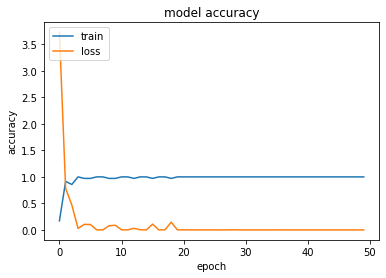

0.013767836530082084
0.28306581227093414
1.0


3

In [23]:
import matplotlib.pyplot as plt

plt.plot(training.history["acc"])
#plt.plot(result.history["X_test"])
plt.plot(training.history["loss"])
#plt.plot(training.history["val_loss"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "loss"], loc="upper left")
plt.show()

print(np.var(training.history["acc"]))
print(np.var(training.history["loss"]))
acc_max = max(training.history["acc"])
print(acc_max)
training.history["acc"].index(acc_max)

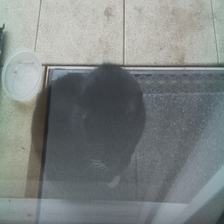

In [24]:
from PIL import Image
#image  = Image.open("/content/Cat-Classifier/data/s/image147.jpg")
#image  = Image.open("/content/Cat-Classifier/data/c/image400.jpg")
image  = Image.open("data/c/image400.jpg")
image = image.resize((224, 224), Image.LANCZOS)
image

In [25]:
image = np.asarray(image)
print(image.shape)

data = image.reshape(1, 224,224,3)
print(data.shape)

(224, 224, 3)
(1, 224, 224, 3)


In [26]:
from tensorflow.keras.models import load_model

np.set_printoptions(suppress=True) 
# base , s, c, o
model1.predict(data).astype(np.float32)

array([[0., 0., 1., 0.]], dtype=float32)

In [27]:
#model1.save("Cat-Classifier/model")
model1.save("model/model.h5")

In [18]:
test = model1

In [19]:
test.predict(data).astype(np.float32)

array([[0.00010883, 0.        , 0.99989116]], dtype=float32)

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\p-bla\AppData\Local\Temp\tmpt1kfhsu8\assets


In [29]:
# Save the model.
with open('model/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [30]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [31]:
#get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_tensor= np.array(np.expand_dims(image,0), dtype=np.float32)

In [32]:
input_index = interpreter.get_input_details()[0]["index"]
interpreter.set_tensor(input_index, input_tensor)
#Run the inference
interpreter.invoke()
output_details = interpreter.get_output_details()[0]

In [33]:
np.squeeze(interpreter.get_tensor(output_details['index']))

array([0., 0., 1., 0.], dtype=float32)

Code für Rasp Zero

In [25]:
interpreter = tf.lite.Interpreter(model_path="model/model.tflite")
interpreter.allocate_tensors()
# input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_tensor= np.array(np.expand_dims(image,0), dtype=np.float32)
input_index = interpreter.get_input_details()[0]["index"]
interpreter.set_tensor(input_index, input_tensor)
#Run the inference
interpreter.invoke()
output_details = interpreter.get_output_details()[0]
np.squeeze(interpreter.get_tensor(output_details['index']))